# T2D benchmark

In [1]:
import takco

conf = takco.config.parse('resources/config-dbpedia.toml')
tables = takco.TableSet.load('output/t2d-v2-baseline/1-split-0/1-link/*')
t2dv2 = takco.config.build('t2d-v2', conf)

takco.preview(takco.TableSet.dataset(t2dv2))

In [14]:
searcher = takco.config.build('dbpedia_t2ksubset_es', conf)
print(searcher)

# Test
with searcher:
    for rs in searcher.search_entities([('USA',{})]):
        print([r.uri for r in rs])

ElasticSearcher(index='dbpediasub-7', baseuri='http://dbpedia.org/resource/', propbaseuri='http://dbpedia.org/ontology/', es_kwargs={'hosts': ['bricks07'], 'timeout': 60}, parts=True, prop_uri={'type': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'}, prop_baseuri={'type': 'http://dbpedia.org/ontology/'}, typer=SimpleTyper(use_dateparser='dateutil'), stringmatch='jaccard')
['http://dbpedia.org/resource/United_States']


In [3]:
from dask.distributed import Client
client = Client(address = 'tcp://192.168.62.207:8786')
client

<Client: 'tcp://192.168.62.207:8786' processes=10 threads=10, memory=673.47 GB>

In [8]:
%%time

baseline = takco.config.build('baseline_linker', conf)


pred = takco.TableSet.link(
    takco.DaskHashBag(takco.TableSet.dataset(t2dv2), client=client).take(10),
    usecols = "keycol",
    linker = baseline,
)

scored = pred.score(t2dv2)
scores.tables.persist()

report = scored.report(keycol_only=True, curve = True )

import pandas as pd
pd.DataFrame.from_dict( report.get('scores'), orient='index' )

CPU times: user 7.7 s, sys: 244 ms, total: 7.94 s
Wall time: 15.5 s


precision    recall  f1-score  support  predictions
entities     0.894435  0.861308  0.877559     1269         1222
properties   0.833333  0.294118  0.434783       17            6
classes      1.000000  1.000000  1.000000       10           10

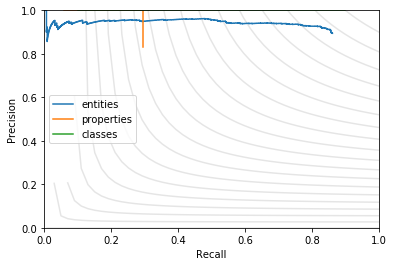

In [9]:
from takco.evaluate import pr_plot
pr_plot(report['curves'])

In [10]:
takco.preview( scored, nrows=None, hide_correct_rows=True )